# Import all Packages

In [2]:
import torch
import gc
import os
import sys
import subprocess
import platform

# Set environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Environment & version checks
# Import CUDA utils from parent folder (preferred), fallback to local
from pathlib import Path

print(f"Python: {sys.version}")
try:
    import torch, transformers
    print("PyTorch:", torch.__version__)
    print("Transformers:", transformers.__version__)
except Exception as e:
    print("You likely need to install torch/transformers:", e)
    
# Try parent directory first (ideal location)
parent_dir = str(Path.cwd().parent)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

try:
    import utils  # expected at ../utils.py
except Exception:
    # Fallback: current working directory
    curr_dir = str(Path.cwd())
    if curr_dir not in sys.path:
        sys.path.insert(0, curr_dir)
    import utils  # tries ./utils.py

from utils import *

print("Loaded utils from:", utils.__file__)
# Set memory env & show current device
utils.setup_memory_environment(expandable_segments=True)
device = utils.get_device()
print("Selected device:", device)

Python: 3.12.11 (main, Jul 23 2025, 00:34:44) [Clang 20.1.4 ]
PyTorch: 2.8.0+cu129
Transformers: 4.56.0
Loaded utils from: /mnt/nfs/workspace/courses/PyTorch/Building-Transformer-Models-with-PyTorch-2.0/utils.py
Memory environment configured
Selected device: cuda


In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Data Preparation
1. We will be using the model `deit_base_patch16_224`
  * This means all image need to be reshaped to (224,224)
2. In training, we are using data augmentation process: `RandomHorizontalFlip`. 
  * It is optional step
  *  It randomly flips an input image horizontally
  * It  artificially increase the size and diversity of the training dataset
3. We also normalizes the image `transforms.Normalize`
  * This will reduce the scale of image
  * It helps on Faster convergence, better generalization, and numercial stability


In [4]:
# Please download the images from `https://www.kaggle.com/datasets/jr2ngb/cataractdataset` and place in your machine's directory
DATA_DIR = "dataset/"
CLASSES = ["1_normal", "2_cataract", "2_glaucoma", "3_retina_disease"]

data = []
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append([img_path, class_idx])

df = pd.DataFrame(data, columns=["image_path", "label"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class CataractDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CataractDataset(train_df["image_path"].values, train_df["label"].values, transform=train_transforms)
test_dataset = CataractDataset(test_df["image_path"].values, test_df["label"].values, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)



# Let's review our dataloader
1. We are just viewing the image from train_dataloader
2. There is one very important step:
  * matplotlib need the image in [H, W, C]; where dataloader has image of shape [C, H,W]
  * Thus, before plotting we are transposing so that the data is suitable for viewing for matplotlib

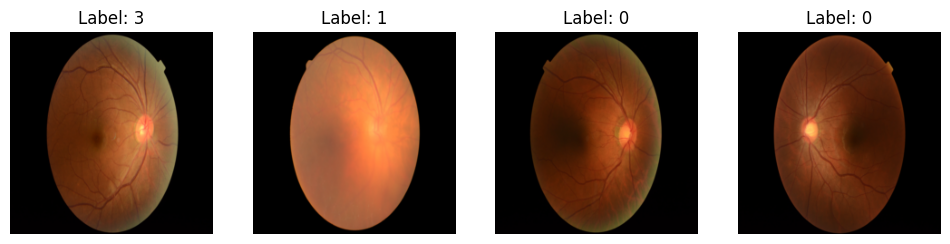

In [5]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(train_loader)
images, labels = next(data_iter)

# Function to unnormalize and convert a tensor image to numpy array
def imshow(img_tensor):
    img = img_tensor.numpy()
    # transposing
    img = np.transpose(img, (1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Display the images and their labels
fig, axes = plt.subplots(1, len(images), figsize=(12, 12))

for idx, (image, label) in enumerate(zip(images, labels)):
    axes[idx].imshow(imshow(image))
    axes[idx].set_title(f"Label: {label.item()}")
    axes[idx].axis("off")

plt.show()


# Declare the model
1. We are using the pre-trained model from timm
2. If the image is color, 
  * in_chans=3;
3. if image is graysclae, 
  * in_chans=3=1
4. We need to declare, how many classes we have in out dataset: 
  * For our case, it was 4.
  * num_classes=4
5. `pretrained=True`
  * We are mentioning that we want weight of pre-trained model. If you want to train from scratch, you could just mention 
    * pretrained=False

In [6]:
import timm
import timm

model = timm.create_model("deit_base_patch16_224", pretrained=True)

# Change the output size of the final linear layer to match the number of classes
num_classes = 4
model.head = torch.nn.Linear(model.head.in_features, num_classes)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# Declare the train and test loop
1. In the below code: I am converting output and target into 'cpu'. Somehow my M1 chip is producing the problem. You may not encounter the problem. Thus, this is totally optional step.

In [7]:
def train(model, device, train_loader, optimizer, criterion, epoch, accelerator):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        accelerator.backward(loss)
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}")

from sklearn.metrics import confusion_matrix, recall_score, precision_score

def test(model, device, test_loader, criterion, accelerator):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            output_cpu = output.to('cpu')
            target_cpu=target.to('cpu')
            pred = output_cpu.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_cpu.view_as(pred)).sum().item()
            
            all_preds.extend(pred.flatten().tolist())
            all_targets.extend(target.flatten().tolist())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Calculate confusion matrix, sensitivity (recall), and specificity
    cm = confusion_matrix(all_targets, all_preds)
    sensitivity = recall_score(all_targets, all_preds, average=None)
    specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)
    
    for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
        print(f"Class {i}: Sensitivity (Recall): {sens:.4f}, Specificity: {spec:.4f}")



In [8]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
model, optimizer, criterion = accelerator.prepare(model, optimizer, criterion)





In [10]:
full_cleanup()

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(model, device, test_loader, criterion, accelerator)
    # Clean up after epoch
    clear_gpu_memory()

GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:30<00:00,  3.62it/s]


Epoch: 1, Loss: 1.0172


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 0.8525, Accuracy: 66.07%
Class 0: Sensitivity (Recall): 0.9667, Specificity: 0.3483
Class 1: Sensitivity (Recall): 0.6500, Specificity: 0.1875
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.5714
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:32<00:00,  3.43it/s]


Epoch: 2, Loss: 1.0293


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.0007, Accuracy: 61.61%
Class 0: Sensitivity (Recall): 0.6333, Specificity: 0.2400
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.0000
Class 2: Sensitivity (Recall): 0.9500, Specificity: 0.6200
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:32<00:00,  3.49it/s]


Epoch: 3, Loss: 0.8605


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 0.8881, Accuracy: 65.18%
Class 0: Sensitivity (Recall): 0.8667, Specificity: 0.3247
Class 1: Sensitivity (Recall): 0.9000, Specificity: 0.3793
Class 2: Sensitivity (Recall): 0.1500, Specificity: 0.5000
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:32<00:00,  3.45it/s]


Epoch: 4, Loss: 0.7759


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 0.8106, Accuracy: 66.96%
Class 0: Sensitivity (Recall): 0.9167, Specificity: 0.3452
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.2857
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.2857
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:32<00:00,  3.42it/s]


Epoch: 5, Loss: 0.7217
Test Loss: 0.8485, Accuracy: 65.18%
Class 0: Sensitivity (Recall): 0.7833, Specificity: 0.3088
Class 1: Sensitivity (Recall): 0.9000, Specificity: 0.3793
Class 2: Sensitivity (Recall): 0.3500, Specificity: 0.5000
Class 3: Sensitivity (Recall): 0.0833, Specificity: 0.0000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:33<00:00,  3.37it/s]


Epoch: 6, Loss: 0.6689
Test Loss: 0.8816, Accuracy: 64.29%
Class 0: Sensitivity (Recall): 0.8500, Specificity: 0.3462
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.2500
Class 2: Sensitivity (Recall): 0.2500, Specificity: 0.5000
Class 3: Sensitivity (Recall): 0.0833, Specificity: 0.7500
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:33<00:00,  3.35it/s]


Epoch: 7, Loss: 0.5831


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 0.8618, Accuracy: 67.86%
Class 0: Sensitivity (Recall): 0.8667, Specificity: 0.2877
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.1765
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.5455
Class 3: Sensitivity (Recall): 0.0000, Specificity: nan
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:33<00:00,  3.35it/s]


Epoch: 8, Loss: 0.5600
Test Loss: 0.9849, Accuracy: 61.61%
Class 0: Sensitivity (Recall): 0.6333, Specificity: 0.2400
Class 1: Sensitivity (Recall): 0.9000, Specificity: 0.4857
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5000
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:33<00:00,  3.35it/s]


Epoch: 9, Loss: 0.4679
Test Loss: 0.8295, Accuracy: 75.00%
Class 0: Sensitivity (Recall): 0.8333, Specificity: 0.2188
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.1176
Class 2: Sensitivity (Recall): 0.7500, Specificity: 0.3478
Class 3: Sensitivity (Recall): 0.3333, Specificity: 0.5000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:33<00:00,  3.33it/s]


Epoch: 10, Loss: 0.4070
Test Loss: 1.2277, Accuracy: 58.93%
Class 0: Sensitivity (Recall): 0.5667, Specificity: 0.2273
Class 1: Sensitivity (Recall): 0.9000, Specificity: 0.4000
Class 2: Sensitivity (Recall): 0.6500, Specificity: 0.5806
Class 3: Sensitivity (Recall): 0.0833, Specificity: 0.8571
GPU memory cleared


# Analysis:
1. The loss is decreasing. We need more epoch.

# Resnet-50

In [11]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [12]:
# Load ResNet-50 model
resnet_model = timm.create_model("resnet50", pretrained=True)

# Change the output size of the final linear layer for ResNet-50 to match the number of classes
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, num_classes)

In [13]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
resnet_model, optimizer, criterion = accelerator.prepare(resnet_model, optimizer, criterion)

In [14]:
full_cleanup()

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(resnet_model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(resnet_model, device, test_loader, criterion, accelerator)
    # Clean up after epoch
    clear_gpu_memory()

GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:28<00:00,  3.92it/s]


Epoch: 1, Loss: 1.4178


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3613, Accuracy: 26.79%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.9000, Specificity: 0.7353
Class 2: Sensitivity (Recall): 0.6000, Specificity: 0.6757
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:29<00:00,  3.76it/s]


Epoch: 2, Loss: 1.4171


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3874, Accuracy: 23.21%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.7826
Class 2: Sensitivity (Recall): 0.4500, Specificity: 0.7353
Class 3: Sensitivity (Recall): 0.1667, Specificity: 0.7778
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:29<00:00,  3.74it/s]


Epoch: 3, Loss: 1.4190


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3848, Accuracy: 22.32%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.8500, Specificity: 0.7500
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.7576
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:29<00:00,  3.73it/s]


Epoch: 4, Loss: 1.4176


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3607, Accuracy: 26.79%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.9500, Specificity: 0.7077
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.7297
Class 3: Sensitivity (Recall): 0.0833, Specificity: 0.9000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:30<00:00,  3.73it/s]


Epoch: 5, Loss: 1.4207


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3689, Accuracy: 24.11%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.8000, Specificity: 0.7681
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.7222
Class 3: Sensitivity (Recall): 0.0833, Specificity: 0.8571
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:29<00:00,  3.74it/s]


Epoch: 6, Loss: 1.4169


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3830, Accuracy: 22.32%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.8000, Specificity: 0.7576
Class 2: Sensitivity (Recall): 0.4500, Specificity: 0.7750
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:30<00:00,  3.72it/s]


Epoch: 7, Loss: 1.4195
Test Loss: 1.3866, Accuracy: 20.54%
Class 0: Sensitivity (Recall): 0.0000, Specificity: 1.0000
Class 1: Sensitivity (Recall): 0.7500, Specificity: 0.7887
Class 2: Sensitivity (Recall): 0.4000, Specificity: 0.7419
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:29<00:00,  3.78it/s]


Epoch: 8, Loss: 1.4182
Test Loss: 1.3547, Accuracy: 21.43%
Class 0: Sensitivity (Recall): 0.0000, Specificity: 1.0000
Class 1: Sensitivity (Recall): 0.6000, Specificity: 0.7966
Class 2: Sensitivity (Recall): 0.4500, Specificity: 0.7907
Class 3: Sensitivity (Recall): 0.2500, Specificity: 0.6667
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:28<00:00,  3.90it/s]


Epoch: 9, Loss: 1.4169


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.3695, Accuracy: 22.32%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.7000, Specificity: 0.7627
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.7778
Class 3: Sensitivity (Recall): 0.0833, Specificity: 0.8750
GPU memory cleared


100%|█████████████████████████████████████████████████████████████████████████████| 112/112 [00:28<00:00,  3.87it/s]


Epoch: 10, Loss: 1.4168
Test Loss: 1.3689, Accuracy: 23.21%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.8000, Specificity: 0.7612
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.7561
Class 3: Sensitivity (Recall): 0.0000, Specificity: 1.0000
GPU memory cleared


/tmp/ipykernel_3149/263114855.py:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)
